# This notebook demonstrates how to do inference with LogicLLaMA and parse the text FOL rule into a syntax tree that can be used elsewhere

In [1]:
import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.3.1
Is CUDA enabled? True


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
# prepare_model_for_intk_training
import torch
from functools import partial
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
from peft import PeftModel, prepare_model_for_kbit_training
from utils import TranslationDataPreparer, ContinuousCorrectionDataPreparer, make_parent_dirs
from fol_parser import parse_text_FOL_to_tree
from generate import llama_generate
from transformers import BitsAndBytesConfig


In [4]:
if torch.cuda.is_available:
    print('cuda enabled')
else:
    print('cpu')

cuda enabled


In [5]:
base_model='DIR/llama_7B' # TODO: fill in with the path to the llama-7b model
prompt_template_path='data/prompt_templates'
load_in_8bit = True
max_output_len = 128

In [6]:
tokenizer = LlamaTokenizer.from_pretrained(base_model)
tokenizer.add_special_tokens({
    "eos_token": "</s>",
    "bos_token": "<s>",
    "unk_token": '<unk>',
    "pad_token": '<unk>',
})
tokenizer.padding_side = "left"  # Allow batched inference

generation_config = GenerationConfig(
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=1
)

# nf8_config = BitsAndBytesConfig(load_in_8bit=True, bnb_8bit_quant_type="nf8")

# llama_model = LlamaForCausalLM.from_pretrained(
#     base_model,
#     quantization_config=nf4_config,
#     device_map='auto',
# )
llama_model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=load_in_8bit,
    torch_dtype=torch.float16,
    device_map='auto',
)


You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
llama_model = prepare_model_for_kbit_training(llama_model)

# LogicLLaMA Translation

In [8]:
peft_path='DIR/LogicLLaMA-7b-direct-translate-delta-v0'

In [9]:
model = PeftModel.from_pretrained(
    llama_model,
    peft_path,
    torch_dtype=torch.float16
)
model.to('cuda:0')

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear8bitLt(
                (bas

In [10]:
data_preparer = TranslationDataPreparer(
    prompt_template_path,
    tokenizer,
    False,
    256 # just a filler number
)

prepare_input = partial(
    data_preparer.prepare_input,
    **{"nl_key": "NL"},
    add_eos_token=False,
    eval_mode=True,
    return_tensors='pt'
)

simple_generate = partial(
    llama_generate,
    llama_model=model,
    data_preparer=data_preparer,
    max_new_tokens=max_output_len,
    generation_config=generation_config,
    prepare_input=prepare_input,
    return_tensors=False
)

## You can try your own sentences

In [11]:
data_point = {'NL': 'The one who created this repo is either a human or an alien'}

In [12]:
full_resp_str, resp_parts = simple_generate(input_str=data_point)

/home/fatema/anaconda3/envs/logic_env/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [13]:
resp_parts

['N/A\n\n', '∃x (CreatedRepo(x) ∧ (Human(x) ∨ Alien(x)))']

In [14]:
rule_str = resp_parts[1]
rule_str

'∃x (CreatedRepo(x) ∧ (Human(x) ∨ Alien(x)))'

## You can parse the text FOL rule into FOL tree

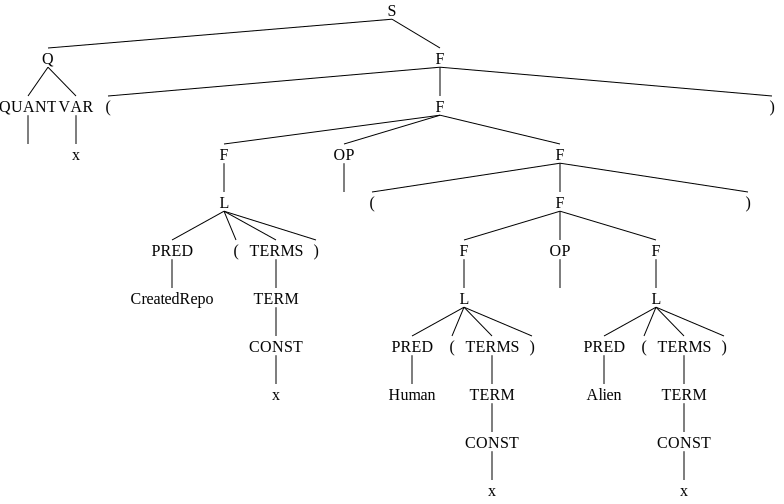

In [15]:
tree = parse_text_FOL_to_tree(rule_str)
tree

# LogicLLaMA Correction

In [29]:
peft_path='yuan-yang/LogicLLaMA-7b-naive-correction-delta-v0'

In [30]:
model = PeftModel.from_pretrained(
    llama_model,
    peft_path,
    torch_dtype=torch.float16
)
model.to('cuda')

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(
                in_features=4096, out_features=4096, bias=Fals

In [17]:
data_preparer = ContinuousCorrectionDataPreparer(
    prompt_template_path,
    tokenizer,
    False,
    256 # just a filler number
)

prepare_input = partial(
    data_preparer.prepare_input,
    **{"nl_key": "NL", "pred_fol_key": "Pred FOL"},
    add_eos_token=False,
    eval_mode=True,
    return_tensors='pt'
)

simple_generate = partial(
    llama_generate,
    llama_model=model,
    data_preparer=data_preparer,
    max_new_tokens=max_output_len,
    generation_config=generation_config,
    prepare_input=prepare_input,
    return_tensors=False
)

In [18]:
data_point = {
    'NL': 'The one who created this repo is either a human or an alien',
    'Pred FOL': 'Created(x, y) ∧ Repo(y) ∧ Human(x)'
}

In [19]:
full_resp_str, resp_parts = simple_generate(input_str=data_point)

In [20]:
rule_str = resp_parts[1]
rule_str

'Created(x, y) ∧ Repo(y) ∧ (Human(x) ∨ Alien(x))'

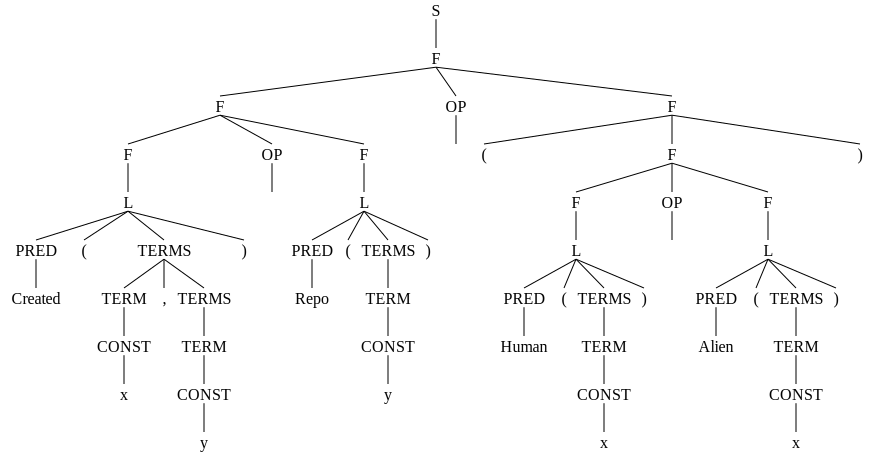

In [22]:
tree = parse_text_FOL_to_tree(rule_str)
tree

# Running on Folio Dataset

In [30]:
from nltk import *
import json
from nltk.sem import logic
from nltk.sem import Expression

logic._counter._value = 0
read_expr = Expression.fromstring

In [34]:
def read_json(filepath):
    with open(filepath, 'r', newline='', encoding='utf-8') as file:
        data = json.load(file)
    # Extract "premise-fol" and "conclusion-fol" fields
    extracted_data = []
    for obj in data:
        extracted_obj = {
            "premises-FOL": obj.get("premises-FOL", []),
            "conclusion-FOL": obj.get("conclusion-FOL", []),
            "premises": obj.get("premises", []),
            "conclusion": obj.get("conclusion", []),
            "label": obj.get("label", []),
        }
        extracted_data.append(extracted_obj)

    return extracted_data

In [35]:
def logicllama_infer(fol_data):
    results = []
    for item in fol_data:
        # Accessing data from the dictionary     
        premises = item.get("premises", [])
        premises_fol_list = []
        for i in range(len(premises)):
            data_point = {'NL': premises[i]}
            _, resp_parts = simple_generate(input_str=data_point)
            premises_fol_list.append(resp_parts[1])

        conclusion = item.get("conclusion", [])
        data_point = {'NL': conclusion}
            _, resp_parts = simple_generate(input_str=data_point)
        conclusion_fol = resp_parts[1]
        print(premises_fol_list)
        print(conclusion_fol)
        results.append({
            "premises-FOL":premises_fol_list,
            "conclusion-FOL":conclusion_fol
            })
    return results
     

In [36]:
with open('/home/fatema/reproduce_paper/logic_llama/Logic_Reasoning_with_LLM/data/logic_llama_folio_validation.json', 'w', encoding='utf-8') as file:
    fol_data = read_json('/home/fatema/reproduce_paper/logic_llama/Logic_Reasoning_with_LLM/data/updated_folio_validation.json')
    results = logicllama_infer(fol_data[:2])
    json.dump(results, file, indent=4)

KeyboardInterrupt: 